In [11]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # 대화형 모드

In [12]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

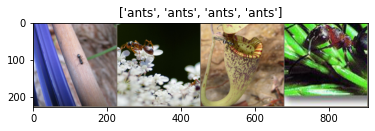

In [15]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_ = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))

        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corr = 0

            for inputs, labels in dataloaders['train']:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, pred = torch.max(outputs,1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corr += torch.sum(pred == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss/ dataset_sizes[phase]
                epoch_acc = running_corr.double()/ dataset_sizes[phase]

                print('{} loss{:.4f} acc {:.4f}'.format(phase, epoch_loss, epoch_acc))
                if phase == 'val' and epoch_acc> best_acc:
                    best_acc = epoch_acc
                    best_model_ = copy.deepcopy(model.state_dict())
            print()
        time_elapsed = time.time() - since
        print('training compelte in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
        print('best val acc {:4f}'.format(best_acc))

        model.load_state_dict(best_model_)
        return model

In [22]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [23]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/gidaehyeon/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [24]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/25
train loss0.0171 acc 0.0041
train loss0.0251 acc 0.0205
train loss0.0322 acc 0.0369
train loss0.0438 acc 0.0451
train loss0.0532 acc 0.0574
train loss0.0689 acc 0.0656
train loss0.0771 acc 0.0779
train loss0.0875 acc 0.0902
train loss0.0940 acc 0.1066
train loss0.1069 acc 0.1107
train loss0.1182 acc 0.1230
train loss0.1297 acc 0.1352
train loss0.1383 acc 0.1434
train loss0.1537 acc 0.1475
train loss0.1610 acc 0.1639
train loss0.1700 acc 0.1762
train loss0.1874 acc 0.1762
train loss0.2011 acc 0.1844
train loss0.2090 acc 0.1967
train loss0.2180 acc 0.2090
train loss0.2254 acc 0.2254
train loss0.2330 acc 0.2377
train loss0.2448 acc 0.2459
train loss0.2588 acc 0.2541
train loss0.2656 acc 0.2664
train loss0.2731 acc 0.2787
train loss0.2858 acc 0.2910
train loss0.2935 acc 0.3033
train loss0.3030 acc 0.3115
train loss0.3090 acc 0.3279
train loss0.3205 acc 0.3402
train loss0.3312 acc 0.3484
train loss0.3374 acc 0.3648
train loss0.3477 acc 0.3730
train loss0.3604 acc 0.3811
train los

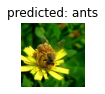

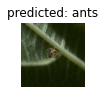

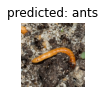

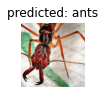

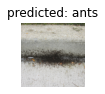

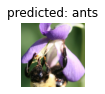

In [26]:
visualize_model(model_ft)

plt.ioff()
plt.show()